# Analyzing neuropil signals in all the mice
* 10/18/23 setup based on `Neuropil_analysis_single_exp.ipynb`
* adding dfof caluclation
* updated 12/27/24

In [13]:
import sys, os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from os.path import join
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import numpy as np

sys.path.append("/home/gergely/code/sleep/src/")

from suite2p_class import Suite2p
from imaging_data_class import ImagingData
from eeg_class import eegData
from behavior_class import behaviorData
import dfof


def freq_calc(data: pd.Series, fs: int = 10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend="linear")
    return frequencies, psd

In [2]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

gcs = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

mcs = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
]

In [21]:
results = {}

for sima_folder in <FOLDER_LIST>:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
    jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)

    # Calculate dfof
    cells = s2p_data.get_cells()
    npil = s2p_data.get_npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)
    npil_dfof = jia_calc_dfof.calculate(signal=npil)

    # Calculate mean dfof
    mean_cellF = cell_dfof.mean(axis=0)
    mean_npilF = npil_dfof.mean(axis=0)

    # Calculate freq and psd of cells
    awake_cell = pd.Series(mean_cellF[df["awake_immobile"]].values)
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    sima_dict["awake_cell"] = {
        "freq": awake_cell_freq,
        "psd": awake_cell_psd,
        "mean_ca": awake_cell,
    }

    nrem_cell = pd.Series(mean_cellF[df["NREM"]].values)
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    sima_dict["nrem_cell"] = {
        "freq": nrem_cell_freq,
        "psd": nrem_cell_psd,
        "mean_ca": nrem_cell,
    }

    # Calculate freq and psd of npil
    awake_immobile_npil = pd.Series(mean_npilF[df["awake_immobile"]].values)
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    sima_dict["awake_immobile_npil"] = {
        "freq": awake_immobile_npil_freq,
        "psd": awake_immobile_npil_psd,
        "mean_ca": awake_immobile_npil,
    }

    nrem_npil = pd.Series(mean_npilF[df["NREM"]].values)
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    sima_dict["nrem_npil"] = {
        "freq": nrem_npil_freq,
        "psd": nrem_npil_psd,
        "mean_ca": nrem_npil,
    }

    results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima
Calculating slow trend


In [22]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,awake_cell,nrem_cell,awake_immobile_npil,nrem_npil
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


In [ ]:
for folder in sima_folders:
    awake_psd_array = results_df["awake_cell"][folder]["psd"]  # Retrieve the psd array
    nrem_psd_array = results_df["nrem_cell"][folder]["psd"]
    x_axis_cell = results_df["awake_cell"][folder][
        "freq"
    ]  # Retrieve the frequency array
    x_axis_nrem = results_df["nrem_cell"][folder]["freq"]

    plt.figure()  # Create a new figure for each plot
    plt.semilogy(
        x_axis_cell, awake_psd_array
    )  # Plot with logarithmic scale on the y-axis
    plt.semilogy(x_axis_nrem, nrem_psd_array)
    plt.title(f"Semilogy plot cells")
    plt.xlabel("Frequency Bin")  # Adjust label as per your data's context
    plt.ylabel("Power Spectral Density")  # Adjust label as per your data's context
    plt.legend(["awake", "nrem"])
    # plt.show()  # Display the plot
    plt.savefig(join(folder, "semilogy_cell.png"), dpi=300)

for folder in sima_folders:
    awake_psd_array = results_df["awake_immobile_npil"][folder][
        "psd"
    ]  # Retrieve the psd array
    nrem_psd_array = results_df["nrem_npil"][folder]["psd"]
    x_axis_cell = results_df["awake_immobile_npil"][folder][
        "freq"
    ]  # Retrieve the frequency array
    x_axis_nrem = results_df["nrem_npil"][folder]["freq"]

    plt.figure()  # Create a new figure for each plot
    plt.semilogy(
        x_axis_cell, awake_psd_array
    )  # Plot with logarithmic scale on the y-axis
    plt.semilogy(x_axis_nrem, nrem_psd_array)
    plt.title(f"Semilogy plot npil")
    plt.xlabel("Frequency Bin")  # Adjust label as per your data's context
    plt.ylabel("Power Spectral Density")  # Adjust label as per your data's context
    plt.legend(["awake", "nrem"])
    # plt.show()  # Display the plot
    plt.savefig(join(folder, "semilogy_npil.png"), dpi=300)

In [19]:
gcs[0]

'/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima'

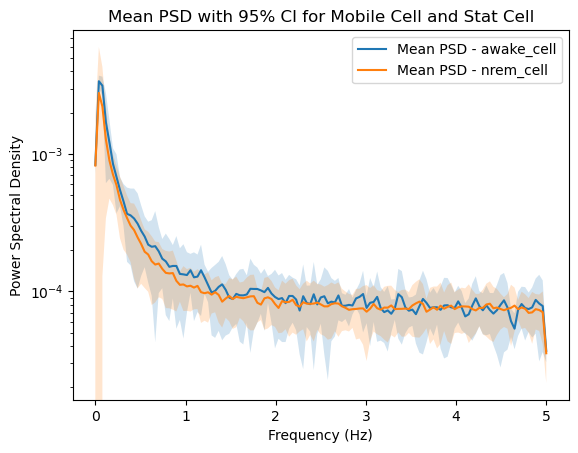

<Figure size 640x480 with 0 Axes>

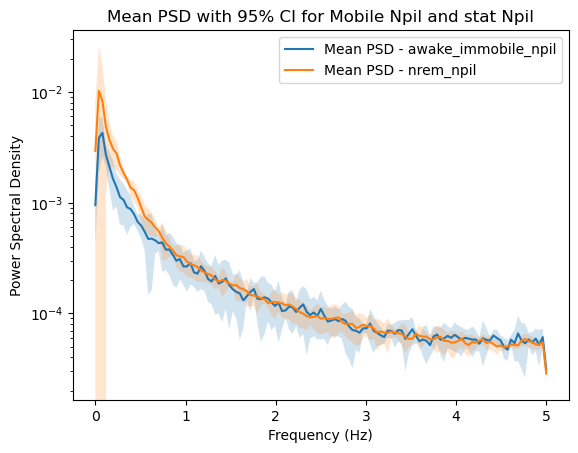

<Figure size 640x480 with 0 Axes>

In [23]:
# Assuming <folder> is a list of folder names and results_df is your DataFrame

# Retrieve the frequency array from the first folder
freq_array = results_df["awake_cell"][<folder>[0]]["freq"]


# Function to calculate mean and SEM
def calculate_mean_sem(data_arrays):
    stack = np.vstack(data_arrays)
    mean = np.mean(stack, axis=0)
    sem = stats.sem(stack, axis=0)
    ci = sem * stats.t.ppf((1 + 0.95) / 2.0, len(data_arrays) - 1)
    return mean, ci


# Plot for mobile_cell and stat_cell
plt.figure()
for condition in ["awake_cell", "nrem_cell"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in <folder>]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(freq_array, mean, label=f"Mean PSD - {condition}")
    plt.fill_between(freq_array, mean - ci, mean + ci, alpha=0.2)

plt.title("Mean PSD with 95% CI for Mobile Cell and Stat Cell")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.show()
plt.savefig("<FOLDER> Cell Mean PSD with 95% CI for awake and NREM.png", dpi=300)

# Plot for mobile_npil and stat_npil
plt.figure()
for condition in ["awake_immobile_npil", "nrem_npil"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in <folder>]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(freq_array, mean, label=f"Mean PSD - {condition}")
    plt.fill_between(freq_array, mean - ci, mean + ci, alpha=0.2)

plt.title("Mean PSD with 95% CI for Mobile Npil and stat Npil")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.show()
plt.savefig("<FOLDER> Npil Mean PSD with 95% CI for awake npil and NREM nplit.png", dpi=300)

## This is a different approach for the same problem

In [30]:
cell_results = {}
npil_results = {}

for sima_folder in sima_folders:
    ##### Data loading and setup
    cell_dict = {}
    npil_dict = {}
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )
    s2p_folder = join(sima_folder, "suite2p")

    ##### Cell calculation
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    cells = s2p_data.cells()
    npil = s2p_data.npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)

    mean_cellF = cell_dfof.mean(axis=0)

    awake_cell = pd.Series(mean_cellF[df["awake_immobile"]].values)
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    cell_dict["cell_awake_freq"] = {"freq": awake_cell_freq}
    cell_dict["cell_awake_psd"] = {"psd": awake_cell_psd}
    cell_dict["cell_awake_Ca"] = {"mean_ca": awake_cell}

    nrem_cell = pd.Series(mean_cellF.loc[df["NREM"]].values)
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    cell_dict["cell_nrem_freq"] = {"freq": nrem_cell_freq}
    cell_dict["cell_nrem_psd"] = {"psd": nrem_cell_psd}
    cell_dict["cell_nrem_Ca"] = {"mean_ca": nrem_cell}

    cell_results[sima_folder] = cell_dict

    ##### Neuropil calculation

    npil_dfof = jia_calc_dfof.calculate(signal=npil)
    mean_npilF = npil_dfof.mean(axis=0)

    awake_immobile_npil = pd.Series(mean_npilF.loc[df["awake_immobile"]].values)
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    npil_dict["npil_awake_freq"] = ({"freq": awake_immobile_npil_freq},)
    npil_dict["npil_awake_psd"] = {"psd": awake_immobile_npil_psd}
    npil_dict["npil_awake_Ca"] = {"mean_ca": awake_immobile_npil}

    nrem_npil = pd.Series(mean_npilF.loc[df["NREM"], 0])
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    npil_dict["npil_nrem_freq"] = {"freq": nrem_npil_freq}
    npil_dict["npil_nrem_psd"] = {"psd": nrem_npil_psd}
    npil_results[sima_folder] = npil_dict

ValueError: Unable to coerce to DataFrame, shape must be (476, 24756): given (72, 36000)

In [ ]:
cell_results_df = pd.DataFrame(cell_results)
npil_results_df = pd.DataFrame(npil_results)

In [ ]:
cell_df = cell_results_df.copy()
cell_awake_arrs = []
cell_nrem_arrs = []
for i in range(len(cell_df.columns)):
    cell_awake_arrs.append(cell_df.loc['cell_awake_psd'][i]['psd'])
    cell_nrem_arrs.append(cell_df.loc['cell_nrem_psd'][i]['psd'])
cell_awake_mean_freq = np.mean(cell_awake_arrs, axis=0)
cell_nrem_mean_freq = np.mean(cell_nrem_arrs, axis=0)

npil_df = npil_results_df.copy()
npil_awake_arrs = []
npil_nrem_arrs = []
for i in range(len(npil_df.columns)):
    npil_awake_arrs.append(npil_df.loc['npil_awake_psd'][i]['psd'])
    npil_nrem_arrs.append(npil_df.loc['npil_nrem_psd'][i]['psd'])
npil_awake_mean_freq = np.mean(npil_awake_arrs, axis=0)
npil_nrem_mean_freq = np.mean(npil_nrem_arrs, axis=0)


In [ ]:
npil_df.loc["npil_awake_freq"][0][0]["freq"]

In [ ]:
# Your data and calculations here

# Create the main plot
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density")
ax[0].plot(
    cell_df.loc["cell_awake_freq"][0]["freq"], cell_awake_mean_freq, label="awake"
)
ax[0].plot(cell_df.loc["cell_nrem_freq"][0]["freq"], cell_nrem_mean_freq, label="nrem")
ax[0].legend(loc="lower right")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Cell signal")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Power/Frequency (dB/Hz)")

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins1 = ax[0].inset_axes(bounds=bounds)
axins1.spines["top"].set_visible(False)
axins1.spines["right"].set_visible(False)

# Plot data in the inset
axins1.plot(
    cell_df.loc["cell_awake_freq"][0]["freq"], cell_awake_mean_freq, label="awake"
)
axins1.plot(cell_df.loc["cell_nrem_freq"][0]["freq"], cell_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins1.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
axins1.set_ylim(0, 7000)  # Modify these values to specify the desired limits

# TODO: hunt down why the indexing is different for the npil data!!!
ax[1].plot(
    npil_df.loc["npil_awake_freq"][0][0]["freq"], npil_awake_mean_freq, label="awake"
)
ax[1].plot(npil_df.loc["npil_nrem_freq"][0]["freq"], npil_nrem_mean_freq, label="nrem")
ax[1].set_title("Npil signal")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].legend(loc="lower right")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins2 = ax[1].inset_axes(bounds=bounds)
axins2.spines["top"].set_visible(False)
axins2.spines["right"].set_visible(False)

# Plot data in the inset
axins2.plot(
    npil_df.loc["npil_awake_freq"][0][0]["freq"], npil_awake_mean_freq, label="awake"
)
axins2.plot(npil_df.loc["npil_nrem_freq"][0]["freq"], npil_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins2.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
axins2.set_ylim(0, 3000)  # Modify these values to specify the desired limits

plt.show()